In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

"""Display float values instead of scientific notations"""
pd.options.display.float_format = "{:.4f}".format      

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import warnings; warnings.simplefilter('ignore')

# Adds higher directory to python modules path.
import sys
sys.path.append('..')

# My stuff
from base_config import BaseConfig
from handler import *
from decomp_arima import DecomposedArima

In [161]:
metric = 'MaxConcurrentStreamsOverall'

minDate = {
    # TODO: I haven't recorded these dats for active devices yet
    'ActiveDevicesAndroid'          : '2017-05-01',
    'ActiveDevicesAppleTV'          : '2017-05-01',
    'ActiveDevicesLinear'           : '2017-05-01',
    'ActiveDevicesOVP'              : '2017-05-01',
    'ActiveDevicesOverall'          : '2017-05-01',
    'ActiveDevicesRoku'             : '2017-05-01',
    'ActiveDevicesSamsungTV'        : '2017-05-01',
    'ActiveDevicesVod'              : '2017-05-01',
    'ActiveDevicesXbox'             : '2017-05-01',
    'ActiveDevicesiOS'              : '2017-05-01',
    
    'MaxConcurrentStreamsAndroid'   : '2017-05-15',
    'MaxConcurrentStreamsAppleTV'   : '2019-01-02',
    'MaxConcurrentStreamsOVP'       : '2018-02-02',
    'MaxConcurrentStreamsOverall'   : '2017-05-15',
    'MaxConcurrentStreamsRoku'      : '2017-05-01',
    'MaxConcurrentStreamsSamsungTV' : '2017-06-01',
    'MaxConcurrentStreamsXbox'      : '2017-05-01',
    'MaxConcurrentStreamsiOS'       : '2017-06-01'
}

In [162]:
modelOb = DecomposedArima(
    dataPath='../data',
    outPath='../out',
    exogPath='../exog',
    runId='4_16_delivery',
    minDateData=minDate[metric],
    metric=metric,
    detectAnomalies=False # Set True to show anomalous dates
)

Initializing V3 model.  Set instance attirbutes directly or they will be inferred.


In [163]:
# patchSeries linearly interpolates between 2 dates, to smooth out anomalies.
# Don't use unless necessary.

# All active device counts have a large dropout on 11/5/19
if modelOb.metric[:13] == 'ActiveDevices':
    print('Patching known data issue with active device counts.')
    modelOb.patchSeries(firstDatePatch='2019-11-05', lastDatePatch='2019-11-05')

# OVP has about a month of very low counts.  I believe this is a data issue.
elif modelOb.metric == 'MaxConcurrentStreamsOVP':
    print('Patching anomalous data for OVP')
    modelOb.patchSeries(firstDatePatch='2018-12-11', lastDatePatch='2019-01-15')

In [164]:
dataset = modelOb.dataset
metric = modelOb.metric
rollingMetric = dataset.rolling(7, center=True).mean()

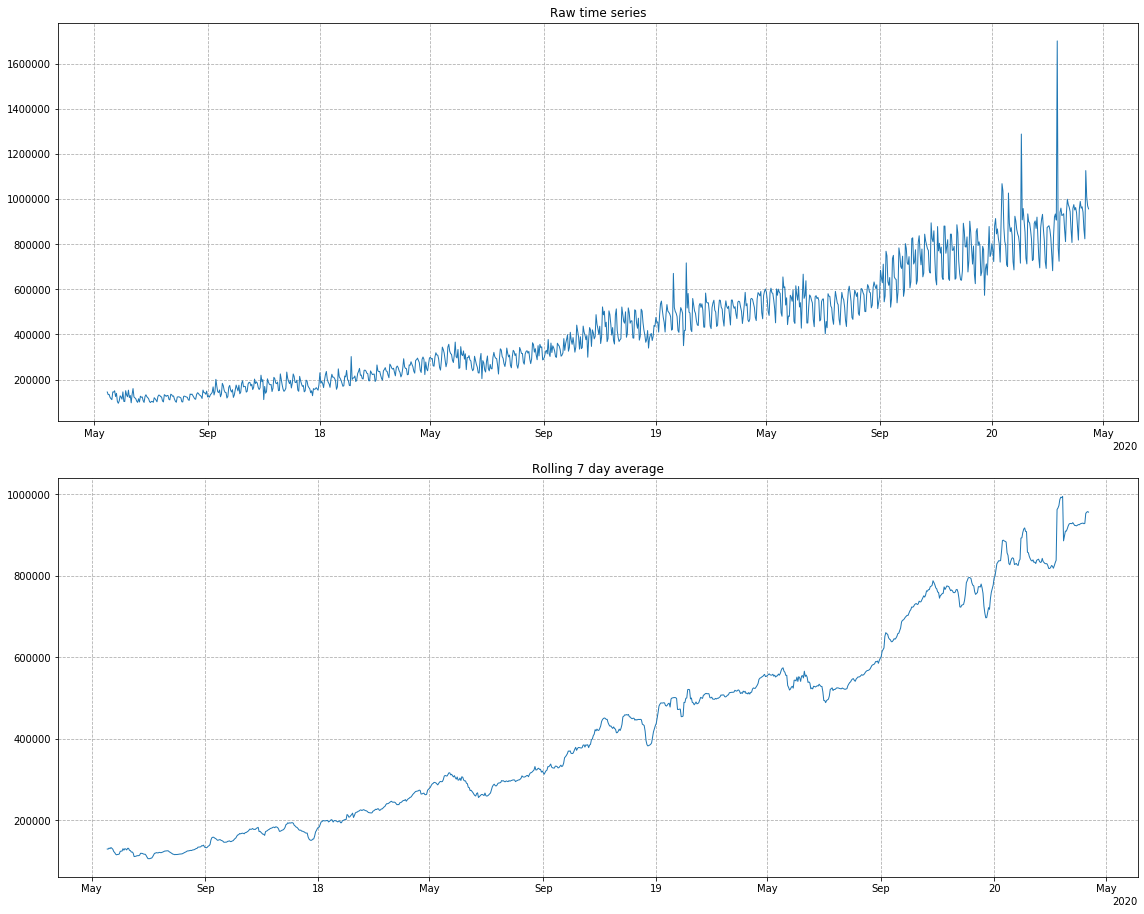

In [165]:
f, axes = plt.subplots(2, 1, figsize=(16, 12.8))
axes[0].plot(dataset.index, dataset[metric], linewidth=1)
axes[0].set_title('Raw time series')
axes[1].plot(dataset.index, rollingMetric, linewidth=1)
axes[1].set_title('Rolling 7 day average')
axes[0].grid(linestyle='dashed')
axes[1].grid(linestyle='dashed')
plt.tight_layout()

In [166]:
# Sometimes boxcox finds optimal lambda < 0.  This is not supposed to happen.
if modelOb.metric == 'MaxConcurrentStreamsAndroid':
    modelOb.setBoxCoxParam(0.4)

In [167]:
predDf, valDf = generateDeliverable(modelOb)

Training and predicting model.
Fitting model.
Learning and saving trend parameters.
Estimating carrying capacity.
Learning Box-Cox parameter.
Learning global trend.
Learning seasonal trend.
Fitting ARIMA.
Generating and saving forecast plot.
Validating model.
Creating new instance to validate.
Initializing V3 model.  Set instance attirbutes directly or they will be inferred.
Fitting model.
Learning and saving trend parameters.
Estimating carrying capacity.
Learning Box-Cox parameter.
Learning global trend.
Learning seasonal trend.
Fitting ARIMA.
Plotting validation metrics.
Saving model raw output.
Saving model summary.
Saving global trend summary.


In [168]:
# For comparison to last month predictions: Average of one week
predDf.loc['2022-03-01':'2022-03-07', 'OoSamplePredictions'].mean()

1763966.3547249313

In [169]:
X = str(modelOb.currentModel.summary())
print(X)

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1067
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -2202.507
Date:                           Thu, 16 Apr 2020   AIC                           4429.014
Time:                                   15:14:43   BIC                           4488.606
Sample:                                        0   HQIC                          4451.599
                                          - 1067                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.3120      0.942      5.638      0.000       3.465       7.159
x2            10.0879      1.207      8.361

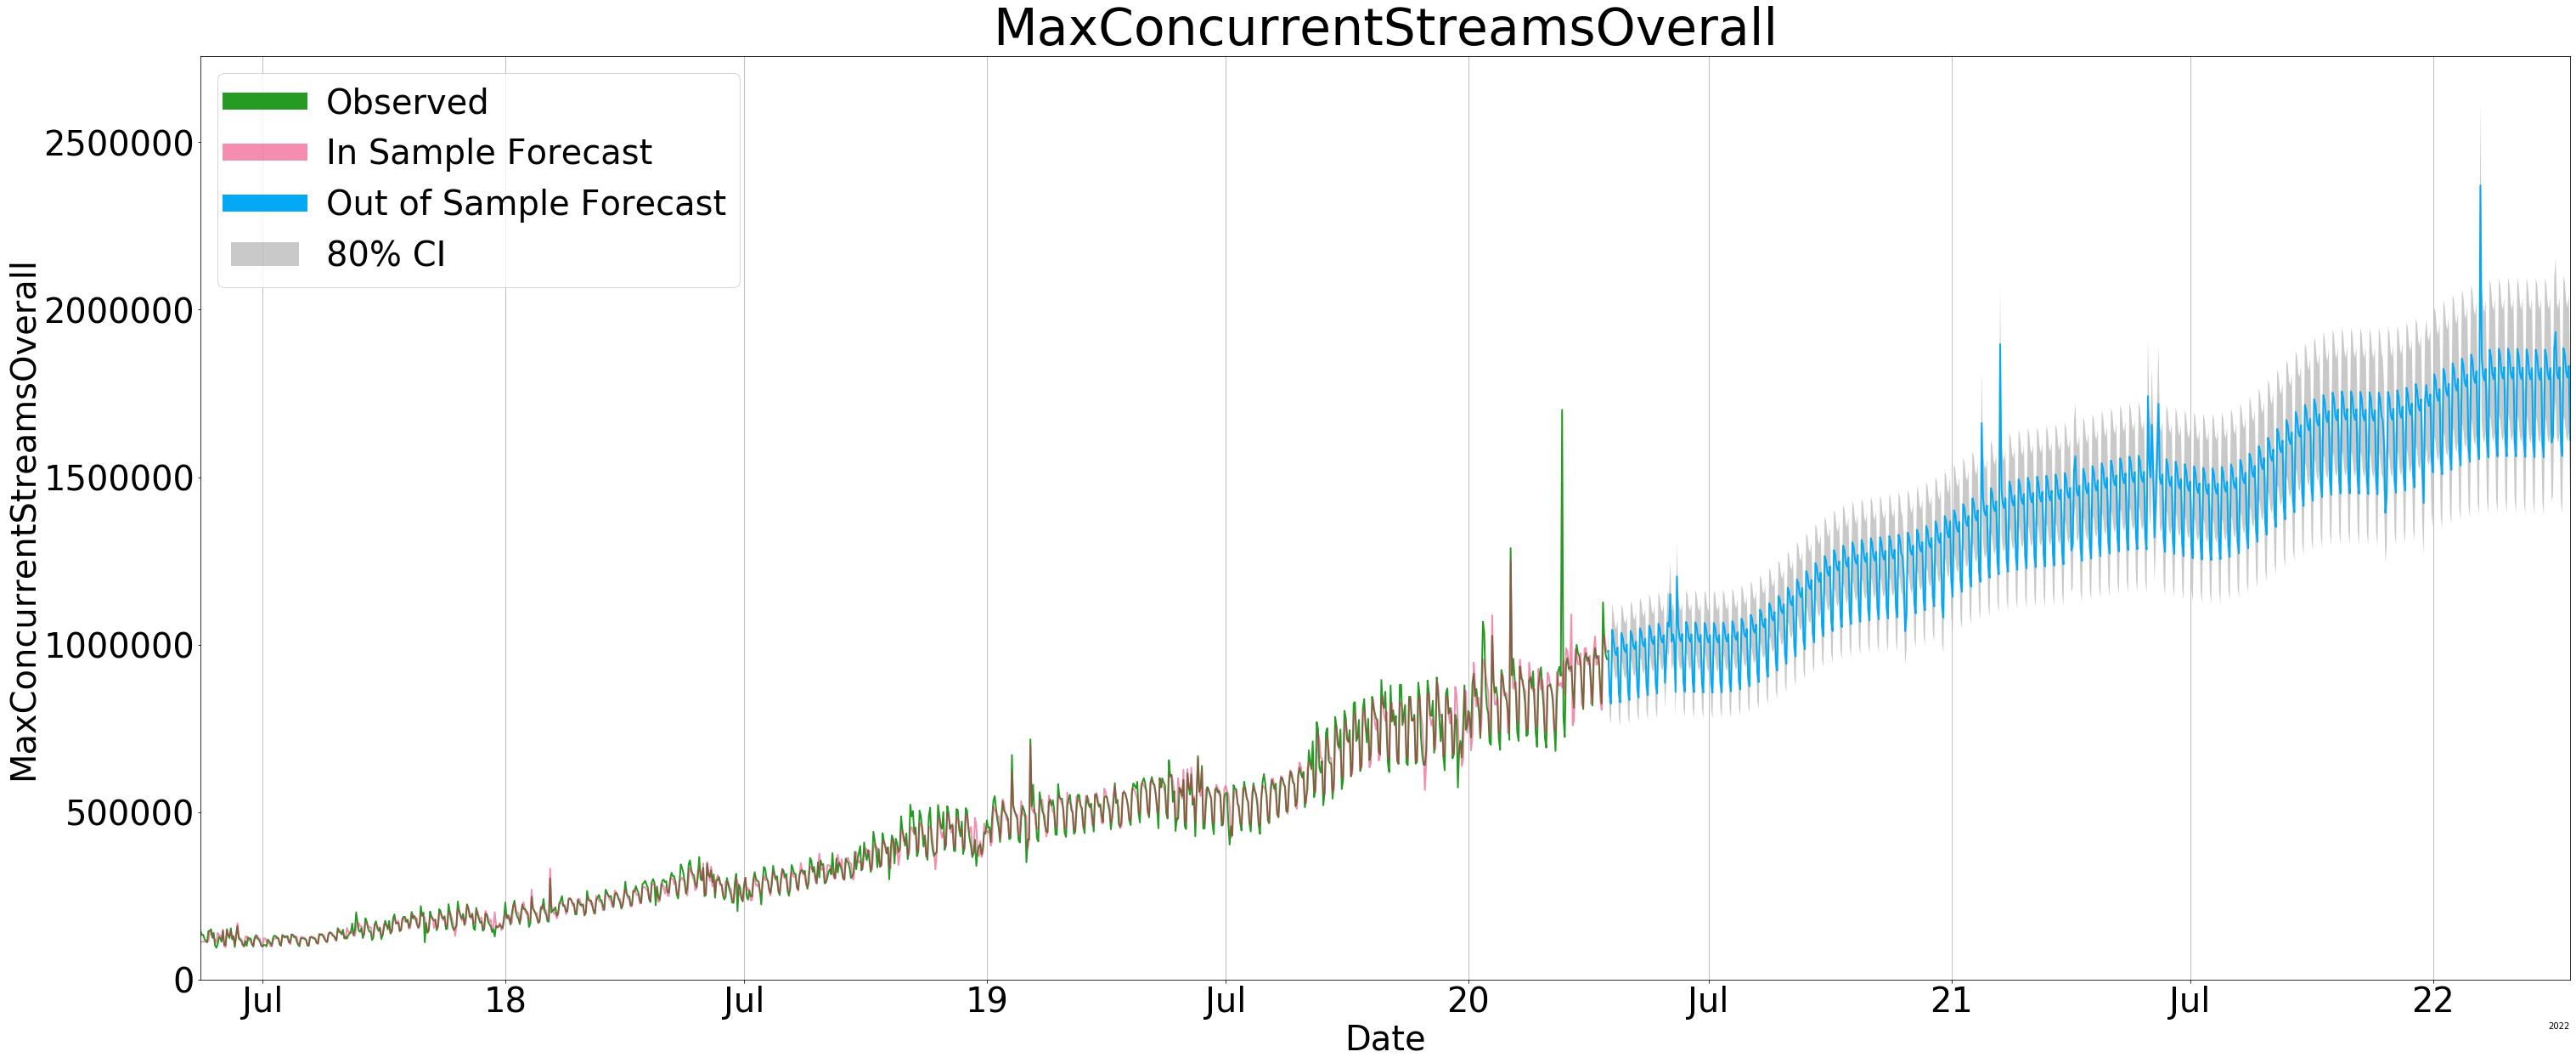

In [175]:
f, ax = plotForecast(
    predDf,
    metric=modelOb.metric,
    #xRange=(pd.to_datetime('2020-02-15'), pd.to_datetime('2020-03-15')),
    #yRange=(1400000, 1800000)
)

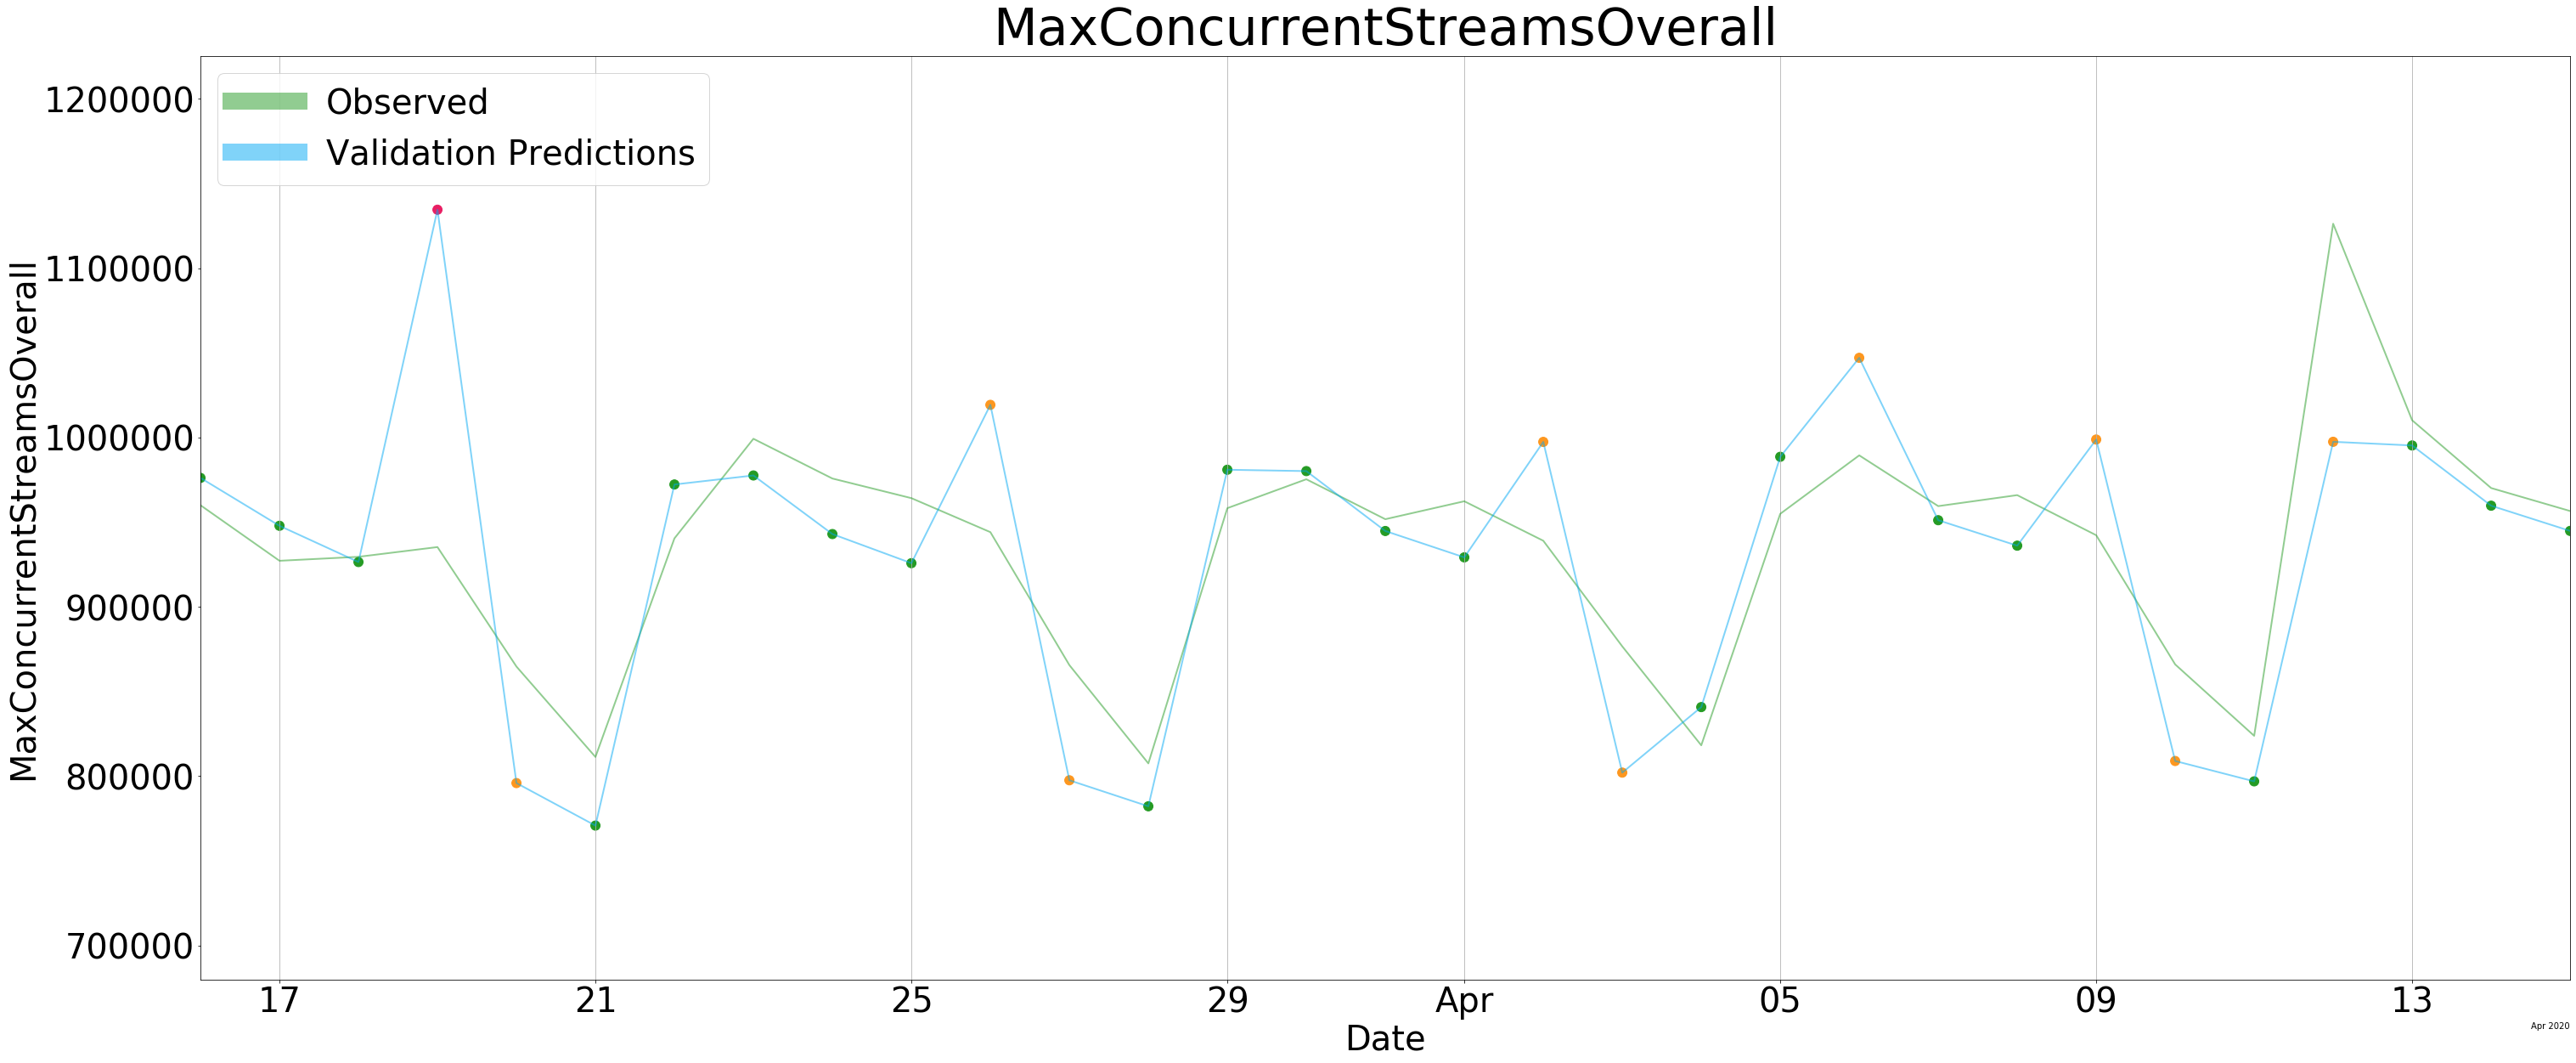

In [171]:
f, ax = plotValidation(valDf, metric=modelOb.metric)

In [172]:
perfDf = valDf.agg({
    'AbsoluteError' : np.mean,
    'SquaredError' : np.mean,
    'PercentError' : np.mean,
    'GREEN' : np.mean,
    'YELLOW' : np.mean,
    'RED' : np.mean,
})
perfDf.index = ['MAE', 'MSE', 'MAPE', 'pct_GREEN', 'pct_YELLOW', 'pct_RED']
perfDf

MAE               41949.2816
MSE          3306527153.8977
MAPE                  4.4910
pct_GREEN             0.6774
pct_YELLOW            0.2903
pct_RED               0.0323
dtype: float64

In [173]:
df = modelOb.exogDf
idx = df[df['superbowl'] == 1].index
predDf.loc[idx]

,MaxConcurrentStreamsOverall,InSamplePredictions,OoSamplePredictions,80%ConfIntLower,80%ConfIntUpper
Date,,,,,
2018-02-04,301897.0000,331377.1348,nan,nan,nan
2019-02-03,717051.0000,700096.2779,nan,nan,nan
2020-02-02,1288157.0000,1253053.5275,nan,nan,nan
2021-02-07,nan,nan,1897035.4024,1733445.6665,2071807.7110
2022-02-06,nan,nan,2371319.2429,2139920.9801,2620780.4642
